<a href="https://colab.research.google.com/github/brunogresende/ppca-aed/blob/main/Aloca%C3%A7%C3%A3o_de_Pessoas_em_Trabalho_Remoto_Scheduling_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Scheduling Problem aplicado à alocação de pessoas em trabalho remoto híbrido na Diretoria de Tecnologia de um banco brasileiro**

**Mestrado Profissional em Computação Aplicada - PPCA - Universidade de Brasília**

**Disciplina**: Algoritmos e Estruturas de Dados

**Orientador**: Prof. Edison Ishikawa

**Alunos**: 
 - Bruno Gomes Resende <bruno.resende@aluno.unb.br>
 - Diego Costa Sombra <diego.sombra@aluno.unb.br>
 - Marilia Bruzadelli Bicalho <marilia.bicalho@aluno.unb.br>
 - Thiago Viana Fernandes <fernandes.viana@aluno.unb.br>

# Introdução

Em decorrência dos diversos desafios enfrentados pelas organizações no período da pandemia do COVID-19, iniciativas de transformação nas dinâmicas de trabalho foram aceleradas, entre elas, a adoção massiva da modalidade de trabalho de forma remota. Pinto, Santos e Martens (2021) realizaram uma análise sobre os impactos da pandemia de COVID-19 nas instituições bancárias brasileiras e apontaram como uma das principais mudanças a realocação dos colaboradores para o trabalho em home-office, caracterizado pela realização das mesmas atividades, habituais do ambiente físico das instituições, mas exercidas direto das residências dos colaboradores.  

Viana, Chitó e Hoffmeister (2022) desenvolveram um estudo de caso no setor bancário para avaliar a percepção dos líderes sobre a produtividade e constataram que os líderes comerciais destacaram o  o contato pessoal primordial para a produtividade, já os líderes técnicos destacaram como primordial a qualidade de vida, maior nível de concentração e maior tempo com a família, que são aspectos observados como resultado do trabalho híbrido. 

Com o controle pandêmico e consequente retorno dos trabalhadores aos postos físicos de trabalho, pode-se aproveitar parte do aprendizado proveniente dessa experiência, trazendo um certo conforto para as organizações, ao lidar com os riscos e desafios do trabalho remoto, instigando-as a adotar perenemente tal modalidade, ou algumas derivações, como é o caso da forma de trabalho remota híbrida, onde o colaborador comparece ao escritório em alguns dias da semana, e permanece remoto nos demais.  

Todavia, para esse novo cenário de trabalho, novos desafios surgiram, entre eles, a alocação justa e bem ponderada dos trabalhadores entre home-office e on-office no trabalho híbrido, atendendo expectativas diversas, tanto dos colaboradores quanto da organização. 

# Descrição
O problema consiste em planejar a alocação mensal de analistas de uma equipe da Diretoria de Tecnologia de um banco brasileiro, em trabalho presencial ou remoto, respeitando as restrições organizacionais para o trabalho híbrido além de buscar uma alocação justa entre os colaboradores, de forma a não impactar negativamente o clima organizacional.  

# Objetivo 
Alcançar o máximo permitido de funcionários em home-office respeitando os requisitos da organização, da equipe analisada, e se possível, respeitando também as restrições relativas às preferências pessoais dos funcionários. 

# Pesquisa Bibliográfica
<TODO>

# Resolução
De forma a combinar as várias restrições associadas para ao cenário descrito e alcançar a maior alocação de funcionários em trabalho remoto no planejamento mensal, iremos elaborar um modelo de maximização utilizando Programação Linear Inteira.

## Configuração de Ambiente

In [590]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpConstraint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math

## Notações Utilizadas
- $  n $     = número de dias do planejamento (pra um mês, $n = 20$)
- $  tajr $  = número total de analistas júniores da equipe
- $  tajr $  = número total de analistas sêniores da equipe
- $  te $    = número total de especialistas da equipe
- $  m $     = quantidade máxima permitida de funcionários fora do escritório $(30\%)$

In [591]:
#Notations
n     = 20  #number of days for planning (20 = 4 weeks)
tAJr  = 20  #number of junior analysts
tASr  = 10  #number of senior analysts
tE    = 5   #number of specialists
max_day_team_absence = math.ceil((tAJr + tASr + tE)*0.3) #max absence allowed in team (30%), ceil rounding


## Variáveis de Decisão
Variáveis de Trabalho Remoto:

- $  ajr_{ij} = 1$, se analista júnior $j$ irá trabalhar remoto no dia $i$; $0$ se não
- $  asr_{ij} = 1$, se analista sênior $j$ irá trabalhar remoto no dia $i$; $0$ se não
- $  e_{ij} = 1$, se especialista $j$ irá trabalhar remoto no dia $i$; $0$ se não

Variáveis de Ausência Programada:

- $  lajr_{ij} = 1$, se analista júnior $j$ tem ausência programada no dia $i$; $0$ se não
- $  lasr_{ij} = 1$, se analista sênior $j$ tem ausência programada no dia $i$; $0$ se não
- $  le_{ij} = 1$, se especialista $j$ tem ausência programada no dia $i$; $0$ se não

In [592]:
#Decision variables
#Absences: 1 if day-off, 0 otherwise
var_LAJr = LpVariable.dicts("AbsenceAJr", (range(n), range(tAJr)), 0, 1, "Binary")
var_LASr = LpVariable.dicts("AbsenceASr", (range(n), range(tASr)), 0, 1, "Binary")
var_LE   = LpVariable.dicts("AbsenceEsp", (range(n), range(tE)), 0, 1, "Binary")

#Remote: 1 if remote work, 0 otherwise
var_AJr = LpVariable.dicts("RemoteAJr", (range(n), range(tAJr)), 0, 1, "Binary")
var_ASr = LpVariable.dicts("RemoteASr", (range(n), range(tASr)), 0, 1, "Binary")
var_E   = LpVariable.dicts("RemoteEsp", (range(n), range(tE)), 0, 1, "Binary")

## Função Objetivo
$$ Max\sum _{i=0}^n\left(\sum _{j=0}^{tajr}ajr_{ij}+\sum _{j=0}^{tasr}asr_{ij}+\sum _{j=0}^{te}e_{ij}\right) $$

In [593]:
#Objective function
obj = None
for i in range(n):
  for j in range(tE):
    obj += var_E[i][j]
  for jj in range(tAJr):
    obj += var_AJr[i][jj]
  for jjj in range(tASr):
    obj += var_ASr[i][jjj]

problem = LpProblem("Schedule", LpMaximize)
problem += obj

## Restrições

### Restrição 0
Configuração de ausências programadas.

In [594]:
#Constraint 0
#Absences configuration

#funci AJr 1, 0-5 dias de férias
for i in range(0,5):
  problem += var_LAJr[i][1] == 1

#funci ASr 0, 5-15 dias de férias
for i in range(5,15):
  problem += var_LASr[i][0] == 1

#funci AJr 5, 15-20 dias de férias
for i in range(15,20):
  problem += var_LAJr[i][5] == 1

#funci Esp 1, 3 dias de abono
for i in range(17,19):
  problem += var_LE[i][1] == 1

#funci AJr 10, 2 dias de abono
for i in range(3,5):
  problem += var_AJr[i][10] == 1

#funci ASr 1, 2 dias de abono
for i in range(4,6):
  problem += var_LASr[i][1] == 1

problem += var_LAJr[0][0] == 1

### Restrição 1
Cada funcionário poderá estar trabalhando remoto (1), trabalhando no escritório (0) ou ausente (1), de forma excludente. 

$$  \sum _{i=0}^n\sum _{j=0}^{tajr}ajr_{ij}+lajr_{ij}\le 1 $$ 

$$⋀$$ 

$$  \sum _{i=0}^n\sum _{j=0}^{tasr}asr_{ij}+lasr_{ij}\le 1 $$ 

$$⋀$$

$$  \sum _{i=0}^n\sum _{j=0}^{te}e_{ij}+le_{ij}\le 1 $$

In [595]:
#Constraint 1
#Cada funcionário poderá estar trabalhando remoto (1), trabalhando no escritório (0) ou ausente (1), de forma excludente. 

c = None

for i in range(n):
  
  for j in range(tAJr):
    c = lpSum(var_AJr[i][j] + var_LAJr[i][j]) <= 1
    problem += c
    
  for jj in range(tASr):
    c = lpSum(var_ASr[i][jj] + var_LASr[i][jj]) <= 1
    problem += c
      
  for jjj in range(tE):
    c = lpSum(var_E[i][jjj] + var_LE[i][jjj]) <= 1
    problem += c 


### Restrição 2
Cada funcionário poderá ser alocado no máximo 8 dias em home-office no mês.

$$  \sum _{j=0}^{tajr}\sum _{i=0}^{n}ajr_{ij}\le 8 $$

$$ ⋀ $$

$$  \sum _{j=0}^{tasr}\sum _{i=0}^{n}asr_{ij}\le 8 $$

$$ ⋀ $$ 

$$  \sum _{j=0}^{te}\sum _{i=0}^{n}e_{ij}\le 8 $$

In [596]:
#Constraint 2 
#Cada funcionário poderá ser alocado no máximo 8 dias em home-office no mês. 
for j in range(tAJr):
  c = None
  for i in range(n):
    c += var_AJr[i][j]
  problem += c <=8

for j in range(tASr):
  c = None
  for i in range(n):
    c += var_ASr[i][j]
  problem += c <=8

for j in range(tE):
  c = None
  for i in range(n):
    c += var_E[i][j]
  problem += c <=8


### Restrição 3
A quantidade máxima de ausências do escritório deve ser 30% do total de funcionários da equipe. 

$$  \sum _{i=0}^n((\sum _{j=0}^{tajr}ajr_{ij}+lajr_{ij}\le m \times n) + (\sum _{j=0}^{tasr}asr_{ij}+lasr_{ij}\le m \times n) + (\sum _{j=0}^{te}e_{ij}+le_{ij}\le m \times n)) $$ 

In [597]:
#Constraint 3
#A quantidade máxima de ausências do escritório deve ser 30% do total de funcionários da equipe. 

c = None
for i in range(n):
  for j in range(tAJr):
    c += var_AJr[i][j] + var_LAJr[i][j]

  for jj in range(tASr):
    c += var_ASr[i][jj] + var_LASr[i][jj]

  for jjj in range(tE):
    c += var_E[i][jjj] + var_LE[i][jjj]

problem += (c <= max_day_team_absence*n)

### Restrição 4
Pelo menos um Especialista deve estar presente no escritório em um dia de trabalho.

$$ \sum _{i=0}^n\sum _{j=0}^{te}e_{ij}+le_{ij}\le te - 1 $$

In [598]:
#Constraint 4
#Pelo menos um Especialista deve estar presente no escritório em um dia de trabalho

for i in range(n):
  c = None
  for j in range(tE):
    c += var_E[i][j] + var_LE[i][j]
  problem += (c <= tE-1)


### Restrição 5
De forma a manter a interação entre o time, todos os colegas devem estar no escritório às quartas-feiras, exceto ausências planejadas.

$$  \sum _{5i=2}^n((\sum _{j=0}^{tajr}ajr_{ij} = 0) + (\sum _{j=0}^{tasr}asr_{ij} = 0) + (\sum _{j=0}^{te}e_{ij} = 0)) $$ 


In [599]:
#Constraint 5
#De forma a manter a interação entre o time, todos os colegas devem estar no escritório às quartas-feiras, exceto ausências planejadas.

for i in range(2,n,5):
  c = None
  for j in range(tAJr):
    c += var_AJr[i][j] 

  for jj in range(tASr):
    c += var_ASr[i][jj] 

  for jjj in range(tE):
    c += var_E[i][jjj] 

  problem += (c == 0)

## Modelo Gerado

In [600]:
#See the modeled problem
print(f"Nr Variables: {problem.numVariables()}")
print(f"Nr Constraints: {problem.numConstraints()}")
print(problem)

Nr Variables: 1400
Nr Constraints: 787
Schedule:
MAXIMIZE
1*RemoteAJr_0_0 + 1*RemoteAJr_0_1 + 1*RemoteAJr_0_10 + 1*RemoteAJr_0_11 + 1*RemoteAJr_0_12 + 1*RemoteAJr_0_13 + 1*RemoteAJr_0_14 + 1*RemoteAJr_0_15 + 1*RemoteAJr_0_16 + 1*RemoteAJr_0_17 + 1*RemoteAJr_0_18 + 1*RemoteAJr_0_19 + 1*RemoteAJr_0_2 + 1*RemoteAJr_0_3 + 1*RemoteAJr_0_4 + 1*RemoteAJr_0_5 + 1*RemoteAJr_0_6 + 1*RemoteAJr_0_7 + 1*RemoteAJr_0_8 + 1*RemoteAJr_0_9 + 1*RemoteAJr_10_0 + 1*RemoteAJr_10_1 + 1*RemoteAJr_10_10 + 1*RemoteAJr_10_11 + 1*RemoteAJr_10_12 + 1*RemoteAJr_10_13 + 1*RemoteAJr_10_14 + 1*RemoteAJr_10_15 + 1*RemoteAJr_10_16 + 1*RemoteAJr_10_17 + 1*RemoteAJr_10_18 + 1*RemoteAJr_10_19 + 1*RemoteAJr_10_2 + 1*RemoteAJr_10_3 + 1*RemoteAJr_10_4 + 1*RemoteAJr_10_5 + 1*RemoteAJr_10_6 + 1*RemoteAJr_10_7 + 1*RemoteAJr_10_8 + 1*RemoteAJr_10_9 + 1*RemoteAJr_11_0 + 1*RemoteAJr_11_1 + 1*RemoteAJr_11_10 + 1*RemoteAJr_11_11 + 1*RemoteAJr_11_12 + 1*RemoteAJr_11_13 + 1*RemoteAJr_11_14 + 1*RemoteAJr_11_15 + 1*RemoteAJr_11_16 + 1*Re

## Resolução do Problema

In [601]:
# Solve the problem
status = problem.solve()

# Print results
print(f"Status: {problem.status}, {LpStatus[problem.status]}")
print(f"Objective: {problem.objective.value()}")


Status: 1, Optimal
Objective: 195.0


## Resultados

### Solução Encontrada

In [602]:
# Print variables final values
for var in problem.variables():
    print(f"{var.name}: {var.value()}")

# Print constraints final values
for name, constraint in problem.constraints.items():
    print(f"{name}: {constraint.value()}")

AbsenceAJr_0_0: 1.0
AbsenceAJr_0_1: 1.0
AbsenceAJr_0_10: 0.0
AbsenceAJr_0_11: 0.0
AbsenceAJr_0_12: 0.0
AbsenceAJr_0_13: 0.0
AbsenceAJr_0_14: 0.0
AbsenceAJr_0_15: 0.0
AbsenceAJr_0_16: 0.0
AbsenceAJr_0_17: 0.0
AbsenceAJr_0_18: 0.0
AbsenceAJr_0_19: 0.0
AbsenceAJr_0_2: 0.0
AbsenceAJr_0_3: 0.0
AbsenceAJr_0_4: 0.0
AbsenceAJr_0_5: 0.0
AbsenceAJr_0_6: 0.0
AbsenceAJr_0_7: 0.0
AbsenceAJr_0_8: 0.0
AbsenceAJr_0_9: 0.0
AbsenceAJr_10_0: 0.0
AbsenceAJr_10_1: 0.0
AbsenceAJr_10_10: 0.0
AbsenceAJr_10_11: 0.0
AbsenceAJr_10_12: 0.0
AbsenceAJr_10_13: 0.0
AbsenceAJr_10_14: 0.0
AbsenceAJr_10_15: 0.0
AbsenceAJr_10_16: 0.0
AbsenceAJr_10_17: 0.0
AbsenceAJr_10_18: 0.0
AbsenceAJr_10_19: 0.0
AbsenceAJr_10_2: 0.0
AbsenceAJr_10_3: 0.0
AbsenceAJr_10_4: 0.0
AbsenceAJr_10_5: 0.0
AbsenceAJr_10_6: 0.0
AbsenceAJr_10_7: 0.0
AbsenceAJr_10_8: 0.0
AbsenceAJr_10_9: 0.0
AbsenceAJr_11_0: 0.0
AbsenceAJr_11_1: 0.0
AbsenceAJr_11_10: 0.0
AbsenceAJr_11_11: 0.0
AbsenceAJr_11_12: 0.0
AbsenceAJr_11_13: 0.0
AbsenceAJr_11_14: 0.0
AbsenceA

### Tempos de Execução

In [603]:
# Print results
print(f"Solution Time: {problem.solutionTime}")
print(f"Solution CPU Time: {problem.solutionCpuTime}")

Solution Time: 0.06105446815490723
Solution CPU Time: 0.06300000002374873


### Criação da Matriz de Alocações

In [604]:
# Initialize Matrix with zeros
matAJr = np.array([0]*n*tAJr).reshape(n,tAJr)
matASr = np.array([0]*n*tASr).reshape(n,tASr)
matEsp = np.array([0]*n*tE).reshape(n,tE)

# Populate matrix with -1 if absence, 1 if remote work
for var in problem.variables():
    m = var.name.split("_")
    if "AJr" in m[0] and var.value() == 1:
        if "Absence" in m[0]:
            matAJr[int(m[1])][int(m[2])] = -1
        else:
            matAJr[int(m[1])][int(m[2])] = 1 
    if "ASr" in m[0] and var.value() == 1:
        if "Absence" in m[0]:
            matASr[int(m[1])][int(m[2])] = -1
        else:
            matASr[int(m[1])][int(m[2])] = 1
    if "Esp" in m[0] and var.value() == 1:
        if "Absence" in m[0]:
            matEsp[int(m[1])][int(m[2])] = -1
        else:
            matEsp[int(m[1])][int(m[2])] = 1

matrix = np.concatenate((matAJr,matASr,matEsp), axis=1)

# Populate matrix with -2 in wednesdays (constraint 5)
for i in range(2,n,5):
    for j in range (tAJr+tASr+tE):
        if matrix[i][j] == 0:
            matrix[i][j] = -2

pmatrix = pd.DataFrame(matrix)
pmatrix


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-1,-1,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,-1,0,1,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,-2,-1,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
3,0,-1,1,1,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,-1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
5,1,1,1,1,0,1,0,0,1,1,...,0,0,1,1,1,0,0,0,0,0
6,1,1,0,1,0,1,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
7,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
8,1,1,0,0,1,1,1,0,1,1,...,0,0,1,0,1,0,0,0,0,0
9,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Visualização da Matriz de Alocações

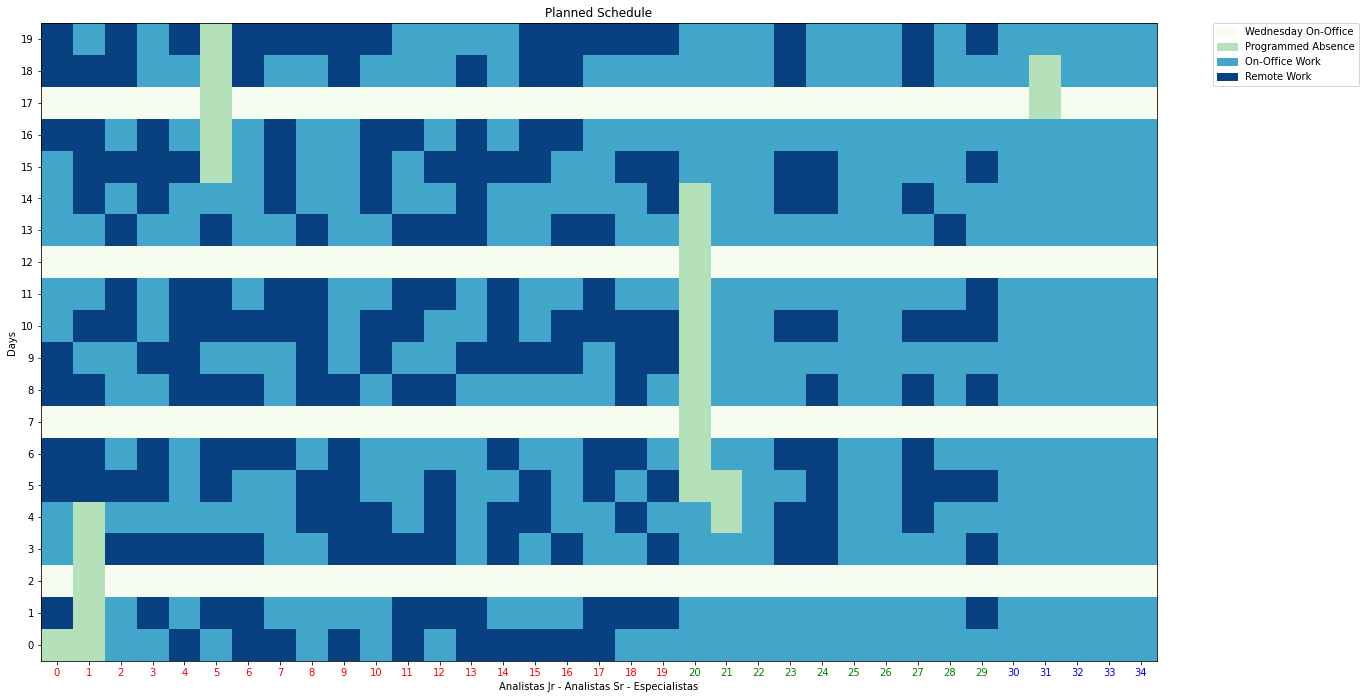

In [605]:
# Show Planned Schedule

plt.figure(figsize=(20,15))
ax = plt.subplot()
im = ax.imshow(matrix, cmap='GnBu')
values = np.unique(matrix.ravel())
leg = ['Wednesday On-Office','Programmed Absence','On-Office Work', 'Remote Work']


ax.set_yticks(list(range(n)))
ax.set_xticks(list(range(tAJr+tASr+tE)))

r = ['r']*tAJr
g = ['g']*tASr
b = ['b']*tE

colors = r+g+b

for xtick, color in zip(ax.get_xticklabels(), colors):
    xtick.set_color(color)

# Setting axes/plot title
ax.set_title('Planned Schedule')
# Setting X-axis and Y-axis labels
ax.set_ylabel('Days')
ax.set_xlabel('Analistas Jr - Analistas Sr - Especialistas')
# invert yaxis 
ax.invert_yaxis()
# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=leg[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

# Comparativo

|n|tAJr|tASr|tE|Method|Executions|Solution Time (mean)|Solution Time (stdev)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|20|20|10|5|ILP|1|0.066|0|
|20|200|100|50|ILP|1|0.436|0|
|20|2000|1000|500|ILP|1|5.47785|0|

# Conclusão

# Referências Bibliográficas
PINTO, A. R. SANTOS, T. A. MARTENS, C. D. P. Impactos da pandemia de COVID-19 sobre o empreendedorismo digital nas instituições bancárias brasileiras: uma análise à luz das forças isomórficas. estud.gerenc.,  Cali ,  v. 37, n. 158, p. 113-125,  Mar.  2021 .   Disponível em: < https://doi.org/10.18046/j.estger.2021.158.4446 >. Acesso em 7 de setembro de 2022. 

VIANA, L. P. CHITÓ, R. E. HOFFMEISTER, D. A PERCEPÇÃO DA LIDERANÇA SOBRE A PRODUTIVIDADE NO TRABALHO HÍBRIDO: UM ESTUDO DE CASO NO SETOR BANCÁRIO. Canoas, v. 10, n. 1, 2022. Disponível em: <http://dx.doi.org/10.18316/cippus.v10i1.9736>. Acesso em 7 de setembro de 2022. 